#### **Import the required libraries**

We will be using a few libraries in this session, import all the required libraries in the cell below one by one as we go through the session.


In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tqdm
import yaml
from PIL import Image
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix,accuracy_score)
from sklearn.model_selection import train_test_split

In [ ]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2024-10-14 15:26:13--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.170.228, 52.219.75.16, 3.5.134.6, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.170.228|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  18.3MB/s    in 1.4s    

2024-10-14 15:26:15 (18.3 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2024-10-14 15:26:15--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.170.228, 52.219.75.16, 3.5.134.

In [ ]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [ ]:
train_images, train_labels = load_mnist('/content', kind='train')
test_images, test_labels = load_mnist('/content', kind='t10k')
print(train_images.shape, train_labels.shape)

print(test_images.shape, test_labels.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


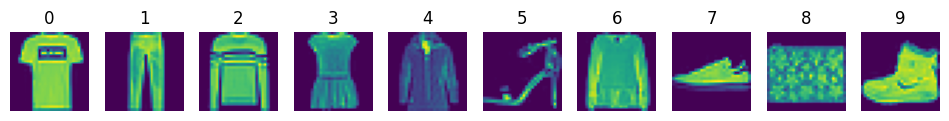

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_names = [str(i) for i in range(10)]

plt.figure(figsize=(12, 12))

for i in range(10):
    index = np.where(train_labels == i)[0][0]

    # Plot the image
    plt.subplot(1, 10, i + 1)  # Create subplots: 1 row, 10 columns
    plt.imshow(train_images[index].reshape(28, 28))
    plt.title(class_names[i])
    plt.axis('off')  # Turn off axes

# Show the plot
plt.show()


In [ ]:
def preprocess_images(images: np.array) -> np.array:
    """
    Preprocess the MNIST images by normalizing and flattening them.

    :param images: The images (grayscale, 1 channel).
    :type images: np.array

    :return: The preprocessed images.
    :rtype: np.array
    """
    # Normalize the images by scaling pixel values to the range [0, 1]
    images = images / 255.0

    # Flatten the images (28x28) to (784,)
    images = images.reshape(-1, 28 * 28)

    return images


In [ ]:
# Preprocess the train and test images
train_images_preprocessed = preprocess_images(train_images)
test_images_preprocessed = preprocess_images(test_images)

print(train_images_preprocessed.shape)
print(test_images_preprocessed.shape)


(60000, 784)
(10000, 784)


#### **Split the data**

We need to split the data into training, testing, and validation sets. We will use `train_test_split` from `sklearn.model_selection` to split the data into training and testing sets. We will use 80% of the data for training and 20% for testing. Then, we will use `train_test_split` again to split the testing data into testing and validation sets. We will use 50% of the testing data for testing and 50% for validation.


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, shuffle=True
)

# Output the shapes to verify the split
print(f"Training set shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, Validation labels shape: {y_val.shape}")


Training set shape: (48000, 784), Training labels shape: (48000,)
Validation set shape: (12000, 784), Validation labels shape: (12000,)


In [ ]:
def random_init(num_features: int, num_classes: int, seed: int = 42) -> tuple:
    """
    Initialize the weights and bias for the model.

    :param num_features: The number of features.
    :type num_features: int
    :param num_classes: The number of classes.
    :type num_classes: int
    :param seed: The random seed.
    :type seed: int

    :return: The weights and bias.
    :rtype: tuple(np.array, np.array)
    """
    np.random.seed(seed)
    W = np.random.randn(num_features, num_classes) * 1e-5
    b = np.random.randn(num_classes) * 1e-3
    return W, b

In [ ]:
def softmax(logits: np.array) -> np.array:
    """
    Compute the softmax of the logits.

    :param logits: The logits.
    :type logits: np.array

    :return: The softmax of the logits.
    :rtype: np.array
    """
    max_logits = np.max(logits, axis=-1, keepdims=True)
    exp_logits = np.exp(logits - max_logits)
    sum_exp_logits = np.sum(exp_logits, axis=-1, keepdims=True)
    softmax = exp_logits / sum_exp_logits
    return softmax


def derivative_softmax(logits: np.array, y: np.array) -> np.array:
    """
    Compute the derivative of the softmax.

    :param logits: The logits.
    :type logits: np.array
    :param y: The labels.
    :type y: np.array

    :return: The derivative of the softmax.
    :rtype: np.array
    """
    return softmax(logits) * (1 - softmax(logits))

In [ ]:
def forward(X: np.array, W: np.array, b: np.array) -> np.array:
    """
    Perform the forward pass.

    :param X: The input data.
    :type X: np.array
    :param W: The weights.
    :type W: np.array
    :param b: The bias.
    :type b: np.array

    :return: The predictions.
    :rtype: np.array
    """
    return softmax(np.dot(X, W) + b)

In [ ]:
def cross_entropy_loss(y, y_pred):
    """
    Calculate the cross-entropy loss.

    :param y: The true labels.
    :type y: np.array
    :param y_pred: The predicted labels.
    :type y_pred: np.array

    :return: The cross-entropy loss.
    :rtype: float
    """
    # Number of samples
    m = y.shape[0]

    # Clip predicted probabilities to avoid log(0)
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)

    # Convert y to one-hot encoding if it's not already
    if y.ndim == 1:  # Check if y is 1-dimensional (class indices)
        # Ensure that class labels start from 0 and are within the valid range
        y = np.eye(y_pred.shape[1])[y - np.min(y)]
    # Calculate the negative log likelihood
    loss = -np.sum(y * np.log(y_pred)) / m

    return loss

In [ ]:
def backward(
    X: np.array,
    y: np.array,
    y_pred: np.array,
) -> tuple:
    """
    Perform the backward pass.

    :param X: The input data.
    :type X: np.array
    :param y: The true labels.
    :type y: np.array
    :param y_pred: The predicted labels.
    :type y_pred: np.array

    :return: The gradients.
    :rtype: tuple(np.array, np.array)
    """
    m = X.shape[0]

    # One-hot encode y to match the shape of y_pred
    num_classes = y_pred.shape[1]  # Assuming y_pred has shape (num_samples, num_classes)
    y_one_hot = np.eye(num_classes)[y] #This will convert the y labels to one hot representation

    dW = (1 / m) * np.dot(X.T, (y_pred - y_one_hot))
    db = (1 / m) * np.sum((y_pred - y_one_hot), axis=0)
    return dW, db

In [ ]:
def update(
    W: np.array,
    b: np.array,
    dW: np.array,
    db: np.array,
    lr: float
) -> tuple:
    """
    Update the weights and bias.

    :param W: The weights.
    :type W: np.array
    :param b: The bias.
    :type b: np.array
    :param dW: The weights gradients.
    :type dW: np.array
    :param db: The bias gradients.
    :type db: np.array
    :param lr: The learning rate.
    :type lr: float

    :return: The updated weights and bias.
    :rtype: tuple(np.array, np.array)
    """
    W -= lr * dW
    b -= lr * db
    return W, b

In [ ]:
def validate(
    X: np.array,
    y: np.array,
    W: np.array,
    b: np.array,
    batch_size: int
) -> tuple:
    """
    Validate the model.

    :param X: The input data.
    :type X: np.array
    :param y: The true labels.
    :type y: np.array
    :param W: The weights.
    :type W: np.array
    :param b: The bias.
    :type b: np.array
    :param batch_size: The batch size.
    :type batch_size: int

    :return: The loss and the predicted labels.
    :rtype: tuple(float, np.array)
    """
    loss_val = 0
    predictions = []
    for i in range(0, X.shape[0], batch_size):
        X_batch = X[i:i+batch_size]
        y_batch = y[i:i+batch_size]
        y_pred = forward(X_batch, W, b)
        loss_ = cross_entropy_loss(y_batch, y_pred)
        loss_val += loss_
        predictions.append(y_pred)
    loss_val /= X.shape[0]
    y_pred = np.concatenate(predictions, axis=0)

    return loss_val, y_pred

In [ ]:
def train(
    X: np.array,
    y: np.array,
    num_classes: int,
    num_epoch: int,
    lr: float,
    batch_size: int,
    seed: int = 42
) -> tuple:
    """
    Train the model.

    :param X: The input data.
    :type X: np.array
    :param y: The true labels.
    :type y: np.array
    :param num_classes: The number of classes.
    :type num_classes: int
    :param num_epoch: The number of epochs.
    :type num_epoch: int
    :param lr: The learning rate.
    :type lr: float
    :param batch_size: The batch size.
    :type batch_size: int
    :param seed: The random seed.
    :type seed: int

    :return: The weights and bias.
    :rtype: tuple(np.array, np.array)
    """
    num_samples, num_features = X.shape
    W, b = random_init(num_features, num_classes, seed)
    loss = {
        "train": [],
        "val": []
    }

    for i in range(num_epoch):
        loss_epoch = 0

        loop = tqdm.tqdm(
            range(0, num_samples, batch_size), leave=False, ncols=100)
        for j in loop:
            X_batch = X[j:j+batch_size]
            y_batch = y[j:j+batch_size]

            # Forward pass
            y_pred = forward(X_batch, W, b)

            # Calculate loss
            loss_ = cross_entropy_loss(
                y_batch, y_pred)
            loss_epoch += loss_

            # Backward pass
            dW, db = backward(X_batch, y_batch, y_pred)

            # Update weights and bias
            W, b = update(W, b, dW, db, lr)

            loop.set_description(f"Epoch [{i+1}/{num_epoch}]")
            loop.set_postfix(loss=loss_)

        loss["train"].append(loss_epoch/num_samples)

        # Validate
        loss_val, y_pred = validate(X, y, W, b, batch_size)
        loss["val"].append(loss_val)

    return W, b, loss

In [ ]:
def plot_loss(loss, batch_size, lr):
    """Plots the training and validation loss."""

    plt.figure(figsize=(10, 6))
    plt.plot(loss['train'], label='Training Loss')
    plt.plot(loss['val'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size}, Learning Rate: {lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()




In [ ]:
def showMetric2(X_val, y_val, weights, bias, batch_size):
    """
    Evaluate the model on validation data and print relevant metrics.

    Parameters:
    - X_val: Validation input data
    - y_val: Validation ground truth labels (one-hot encoded or class indices)
    - weights: Learned weights from the model
    - bias: Learned bias from the model
    - batch_size: The batch size used in training

    Returns:
    - metrics: A dictionary containing accuracy, precision, recall, F1-score, and confusion matrix
    """

    # Predict on the validation data
    _, y_pred = validate(X_val, y_val, weights, bias, batch_size)

    y_pred = np.argmax(y_pred, axis=1)


    unique_classes = np.unique(y_val)
    class_labels = [f"Class {i}" for i in unique_classes]

    # Calculate f1_score
    accuracy = accuracy_score(y_val, y_pred)



    # # Confusion Matrix Display
    # disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_pred), display_labels=class_labels)
    # disp = disp.plot(xticks_rotation=45)  # Rotate x-axis labels by 45 degrees
    # plt.title('Confusion Matrix on Validation Data')
    # plt.show()



    # print("\nClassification Report:")
    # print(classification_report(y_val, y_pred, target_names=class_labels))

      # # Create a dictionary of metrics to return
    f1_score = {'accuracy': accuracy}

    return f1_score


Training with Batch Size: 2048, Learning Rate: 0.001


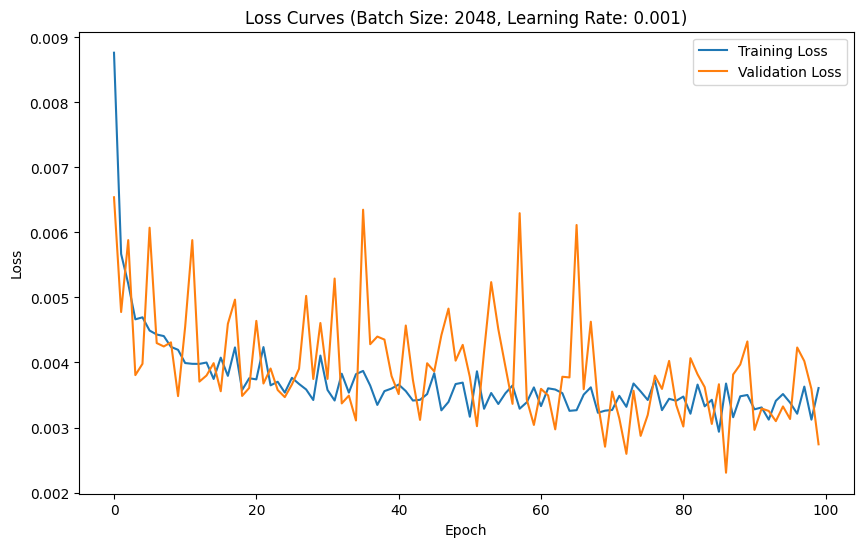


Training with Batch Size: 2048, Learning Rate: 0.0001


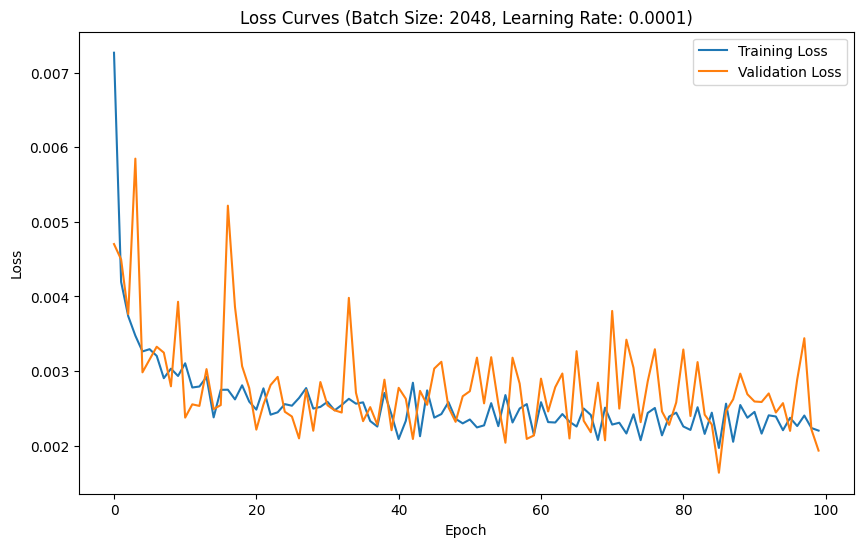


Training with Batch Size: 1024, Learning Rate: 0.001


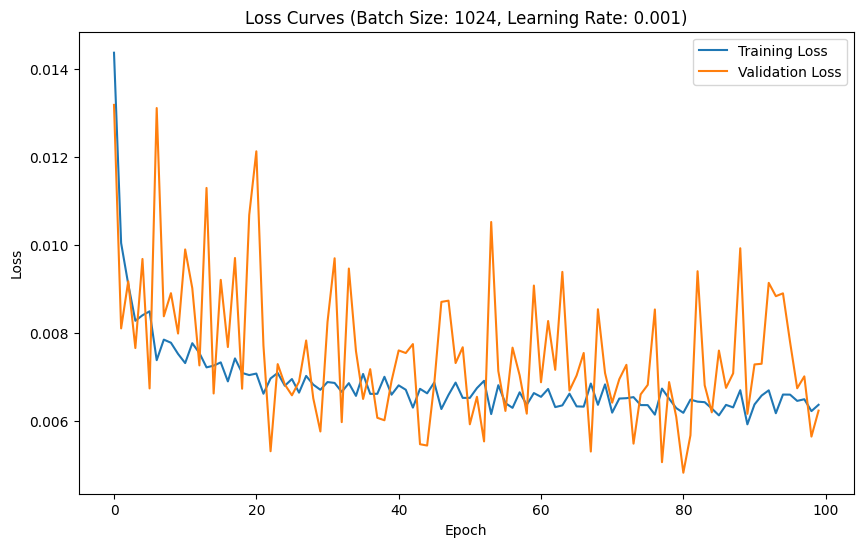


Training with Batch Size: 1024, Learning Rate: 0.0001


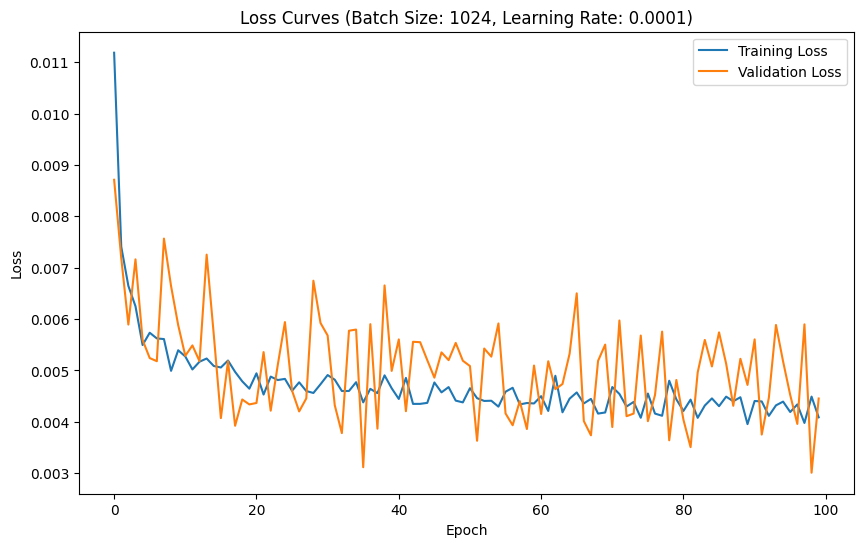


Training with Batch Size: 512, Learning Rate: 0.001


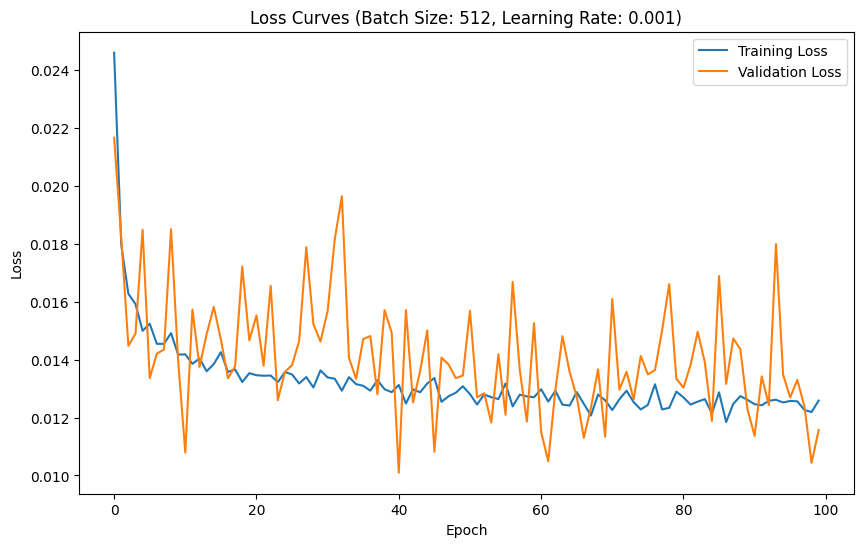


Training with Batch Size: 512, Learning Rate: 0.0001


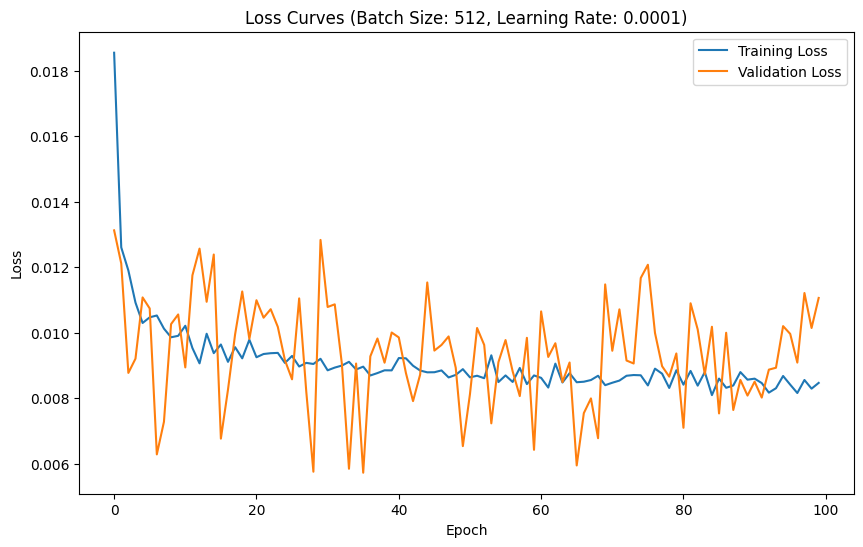

In [ ]:
# Define batch sizes and learning rates
batch_sizes = [2048, 1024, 512]
learning_rates = [0.001, 0.0001]
epochs = 100

# Store results for each combination
results = []

# Run experiments
for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f"\nTraining with Batch Size: {batch_size}, Learning Rate: {lr}")

        # Train the model
        W, b, loss = train(X_train, y_train, 10, epochs, lr, batch_size, seed=42)

        # Calculate metrics including F1-score, using the trained W and b
        f1_score = showMetric2(X_val, y_val, W, b, batch_size)

        # Store results including the F1-score
        results.append({
            'batch_size': batch_size,
            'learning_rate': lr,
            'f1_score': f1_score
        })

        # Plot the loss
        plot_loss(loss, batch_size, lr)




In [ ]:
print(results)

[{'batch_size': 2048, 'learning_rate': 0.001, 'f1_score': {'accuracy': 0.8189166666666666}}, {'batch_size': 2048, 'learning_rate': 0.0001, 'f1_score': {'accuracy': 0.803}}, {'batch_size': 1024, 'learning_rate': 0.001, 'f1_score': {'accuracy': 0.78525}}, {'batch_size': 1024, 'learning_rate': 0.0001, 'f1_score': {'accuracy': 0.774}}, {'batch_size': 512, 'learning_rate': 0.001, 'f1_score': {'accuracy': 0.80025}}, {'batch_size': 512, 'learning_rate': 0.0001, 'f1_score': {'accuracy': 0.7440833333333333}}]


In [ ]:


# Find the best result based on 'accuracy' in f1_score
best_result = max(results, key=lambda x: x['f1_score']['accuracy'])

best_batch_size = best_result['batch_size']
best_learning_rate = best_result['learning_rate']

print(f"Best Batch Size: {best_batch_size}, Best Learning Rate: {best_learning_rate}")


Best Batch Size: 2048, Best Learning Rate: 0.001


In [ ]:
best_W, best_b, best_loss = train(X_train, y_train, 10, epochs, best_learning_rate, best_batch_size, seed=42)


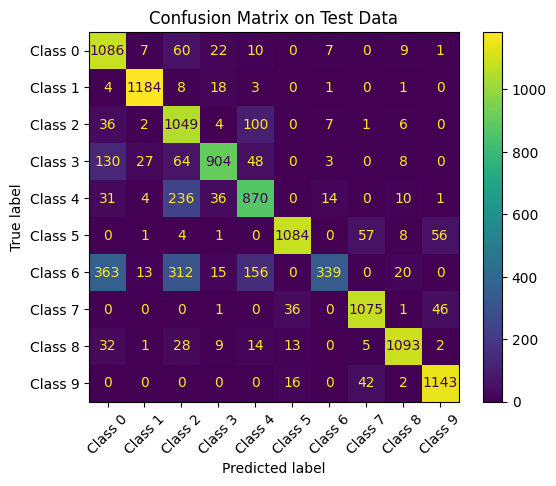


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.65      0.90      0.75      1202
     Class 1       0.96      0.97      0.96      1219
     Class 2       0.60      0.87      0.71      1205
     Class 3       0.90      0.76      0.82      1184
     Class 4       0.72      0.72      0.72      1202
     Class 5       0.94      0.90      0.92      1211
     Class 6       0.91      0.28      0.43      1218
     Class 7       0.91      0.93      0.92      1159
     Class 8       0.94      0.91      0.93      1197
     Class 9       0.92      0.95      0.93      1203

    accuracy                           0.82     12000
   macro avg       0.84      0.82      0.81     12000
weighted avg       0.84      0.82      0.81     12000



In [ ]:
def showTestMetrics2(X_test, y_test, weights, bias, batch_size):
    # Predict on the test data
    _, y_pred = validate(X_test, y_test, weights, bias, batch_size)

    y_pred = np.argmax(y_pred, axis=1)

    # Ensure correct label format for y_test
    if len(y_test.shape) > 1:  # One-hot encoded labels
        y_test = np.argmax(y_test, axis=1)

    # Calculate metrics
    unique_classes = np.unique(y_test)  # Get unique classes from y_test
    class_labels = [f"Class {i}" for i in unique_classes]

    accuracy = accuracy_score(y_test, y_pred)

    # Confusion Matrix Display
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=class_labels)
    disp = disp.plot(xticks_rotation=45)  # Rotate x-axis labels by 45 degrees
    plt.title('Confusion Matrix on Test Data')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_labels))

    return accuracy

# Evaluate on test set
test_accuracy = showTestMetrics2(X_val, y_val, best_W, best_b, best_batch_size)


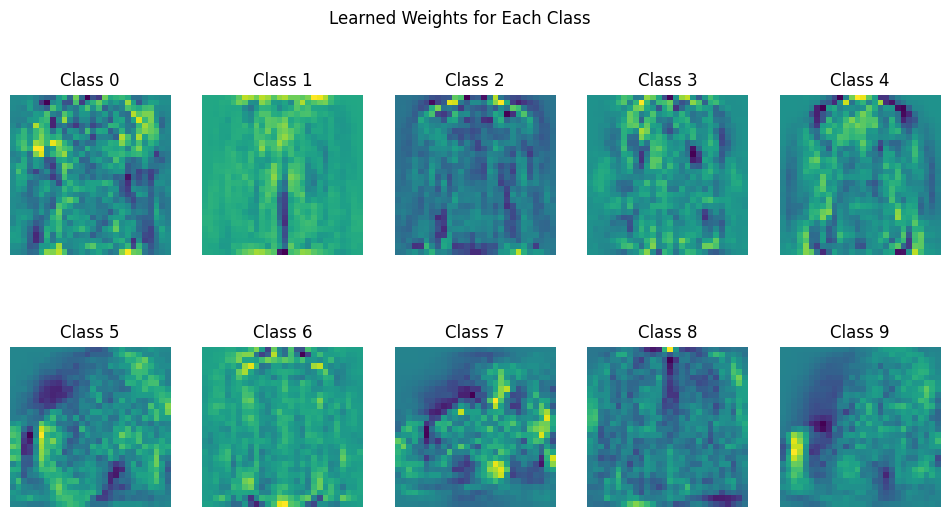

In [ ]:
def plotLearnedWeights(weights, image_shape):
    """
    Visualize the learned weights for each class.

    Parameters:
    - weights: The learned weight matrix, where each row corresponds to a class.
    - image_shape: The shape of the image (e.g., (28, 28) for MNIST images)
    """
    num_classes = weights.shape[1]
    plt.figure(figsize=(12, 6))
    for i in range(num_classes):
        weight_image = weights[:, i].reshape(image_shape)

        # Plot the image
        plt.subplot(2, 5, i + 1)
        plt.imshow(weight_image, cmap='viridis')
        plt.title(f"Class {i}")
        plt.axis('off')

    plt.suptitle('Learned Weights for Each Class')
    plt.show()

# Assuming MNIST Fashion data where images are 28x28
image_shape = (28, 28)

# Plot the learned weights
plotLearnedWeights(best_W, image_shape)
